# Nutrient - Phytoplankton - Zooplankton Model

## Introduction

An Nutrient - Phytoplankton - Zooplankton (NPZ) model is used to simulate elemental cycles at the lowest levels of the marine trophic chain. In this case, there are two levels: the phytoplankton and the zooplankton. Phytoplankton, which are the primary producers, are autotrophs - they "produce" their own food - by incorporating elements present in the water in inorganic form (the nutrient pool), such as nitrate (NO3), in a process called nutrient uptake. The zooplankton, which are herbivores, are heterotrophs - they cannot produce their own food - and ingest autotrophs in a process called grazing. Finally, to close the cycle, nutrients in organic matter are returned to an inorganic form (remineralization) and go into the nutrient pool.  

## Model equations

The model equations for the three model compartments N, P and Z are:

(1) dP/dt = (G)rowth - (M)ortality - graz(I)ng,

(2) dZ/dt = (1 - g) * graz(I)ng - mor(T)ality,

(3) dN/dt = -(G)rowth + (M)ortality + mor(T)ality + g * graz(I)ng.

The model currency is N and its total Nt = P + Z + N, is conserved, as (1) + (2) + (3) = 0. 

Nutrient uptake occurs through the growth term G in (1), and the nutrients move to the higher trophic level trough the grazing term I, that appears in (1) as a loss and in (2) as a gain. Phyto and zooplankton mortalities M and T, move nutrients from the two trophic levels to the nutrient pool. In (3) there is an additional term g * I, that represents the amount of unassimilated ingested phytoplankton that goes to the nutrient pool. 

Phytoplankton growth is modeled as a Michaelis-Menten form:

(4) G = (Vm * N)/(Ks + N) * P,

where Vm is the maximum growth rate and Ks is the half-saturation constant. Phytoplankton mortality is a simple linear function:

(5) M = m * P,

where m is the linear loss rate. The grazing term is a Holling Type II form (Ivlev,1955):

(6) I = Rm * (1 - exp(-A * P)) * Z,

where Rm is the maximum ingestion rate and A the rate at which saturation is achieved with increasing food levels.
Zooplankton mortality is also linear:

(7) T = s * Z,

with s the linear loss rate. In (2) and (3), g is the fraction of ingested phytoplankton that is not assimilated.

Ref: Franks, P. J. S., J. S. Wroblewski, and G. R. Flierl. “Behavior of a Simple Plankton Model with Food-Level Acclimation by Herbivores.” Marine Biology 91, no. 1 (April 1986): 121–29. https://doi.org/10.1007/BF00397577.



## How to run the notebook

In [12]:
# Imports and default settings

from scipy.integrate import solve_ivp
import math
import numpy as np
import matplotlib.pyplot as plt



In [16]:
## MODEL EQUATIONS 

# We define a function that contains the model equations and is called by the time integrator every time step.

def NPZ_Franks(t,y,s,m,g,Rm,Vm,ks,A):
    # Function NPZ_Franks: computes the RHS of the Franks et al. (1986) NPZ model. 
    #
    # t - time
    # y - solution vector y=[P,Z,N]
    
    # Phytoplankton 
    G = (Vm * y[2])/(ks + y[2]) * y[0]         # Growth
    M = m * y[0]                               # Loss
    I = Rm * (1 - math.exp(-A * y[0])) * y[1]  # Grazing
    
    # Zooplankton
    T = s * y[1]                               # Loss
    
    # Return RHS 
    return [G - M - I, (1-g) * I - T, -G + M + T + g * I]
    
    

In [17]:
## USER INPUT

# Model parameters 

zooLoss          = 0.2        # Zooplankton linear loss rate s (d^-1) 
phytoLoss        = 0.1        # Phytoplankton linear loss rate m (d^-1)
zooGrazingEff    = 0.3        # Zooplankton grazing efficiency g
zooMaxIngest     = 1.8        # Zooplankton maximum ingestion rate Rm (d^-1)
phytoMaxGrowth   = 2.0        # Phytoplankton maximum growth rate Vm (d^-1)
phytoHalfSat     = 0.1        # Phytoplankton half-saturation constant ks (mmol N m^-3)
zooSaturation    = 1.10       # Zooplankton saturation rate A (1/(mmol N m^-3))

# Initial conditions

initialP = 0.08      # Initial value of phytoplankton concentration mmol N m^-3
initialZ = 0.06      # Initial value of zooplankton concentration mmol N m^-3
initialN = 1.67      # Initial value of nutrient concentration mmol N m^-3

# Integration time interval 

initialTime = 0         # Initial time in days
finalTime = 40        # Final time in days

# Output interval of the solution

outputInterval = 10 # In minutes

## END OF USER INPUT

# Here we define tuples that contain:
# 1)the model parameters and that will be passed to solve_ip

modelParams = (zooLoss,phytoLoss,zooGrazingEff,zooMaxIngest,phytoMaxGrowth,phytoHalfSat,zooSaturation)

# 2) the initial conditions

initialConditions = [initialP, initialZ, initialN]

# 3) The time span of the integration

timeSpan = (initialTime,finalTime)

# 4) The output times that we want

outputSize = (finalTime - initialTime) / (outputInterval/(24*60)) # Change output interval from minutes to days
outputTimes = np.linspace(initialTime,finalTime,num=int(outputSize),endpoint=True)

In [22]:
## SOLVE MODEL

modelSolution = solve_ivp(NPZ_Franks, timeSpan, initialConditions, method='RK45', t_eval=outputTimes, args=modelParams)

# Print solver message
print(modelSolution.message)

The solver successfully reached the end of the integration interval.


Text(0.5, 1.0, 'Trajectory in (P,Z) phase-space')

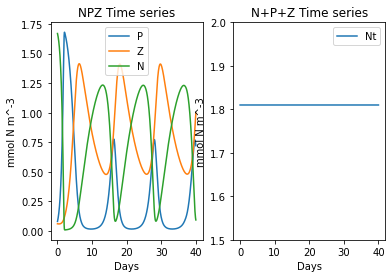

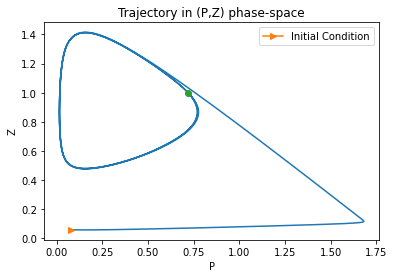

In [48]:
## PLOT SOLUTION

# Time Series !!! Fix the positon of the axes and increases size of figures
fig1, (ax1, ax2) = plt.subplots(1, 2)
# N, P, Z
ax1.plot(modelSolution.t,modelSolution.y[0],label="P")
ax1.plot(modelSolution.t,modelSolution.y[1],label="Z")
ax1.plot(modelSolution.t,modelSolution.y[2],label="N")
ax1.set_xlabel("Days")
ax1.set_ylabel("mmol N m^-3")
ax1.legend()
ax1.set_title("NPZ Time series")

# N + P + Z
Nt = modelSolution.y[0]+modelSolution.y[1]+modelSolution.y[2] # Total nutrients
ax2.plot(modelSolution.t,Nt,label="Nt")
ax2.set_ylim(1.5,2.0)
ax2.set_xlabel("Days")
ax2.set_ylabel("mmol N m^-3")
ax2.legend()
ax2.set_title("N+P+Z Time series")

# Phase space

fig2, ax = plt.subplots()
ax.plot(modelSolution.y[0],modelSolution.y[1])
ax.plot(modelSolution.y[0][0],modelSolution.y[1][0],marker=">",label="Initial Condition")
ax.plot(modelSolution.y[0][-1],modelSolution.y[1][-1],marker="o")
ax.set_xlabel("P")
ax.set_ylabel("Z")
ax.legend()
ax.set_title("Trajectory in (P,Z) phase-space")

In [34]:
dir(ax2)

['ArtistList',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_deprecate_noninstance',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_